In [9]:
import torch
import torch.nn as nn
from torch.optim import SGD, lr_scheduler
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from copy import deepcopy
import pickle
import random
from sklearn.preprocessing import LabelBinarizer      # while displaying test results
import numpy as np

import os                                       
import matplotlib.pyplot as plt

import vgg
from timeit import default_timer as timer

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define a parameter list

In [70]:
all_VGG_configs = {
    
    # available configurations: VGG11-A, VGG13-B, VGG16-C, VGG16-D, VGG19-E
    'VGG_A': [vgg.myVGG11, 'vgg_A_model'],
    'VGG_B': [vgg.myVGG13, 'vgg_B_model'],
    'VGG_C': [vgg.myVGG16_less_conv, 'vgg_C_model'],
    'VGG_D': [vgg.myVGG16, 'vgg_D_model'],
    'VGG_E': [vgg.myVGG19, 'vgg_E_model']
}

In [69]:
param_list = {
    'confg': all_VGG_configs['VGG_A'][0],
    'saved_model_name': all_VGG_configs['VGG_A'][1],
    'epochs': 2,
    'batch_size': 64,
    'learning_rate': 0.01,
    'l2_weight_decay': 5e-4,
    'img_dim': 224,
    'val_percentage': 10,
    'dataset': 'CIFAR10'
}

# Step 1: Data preprocessing

We need to define any preprocessing transformation on the data if required for the network. Transforms has been applied as per the VGG paper which says: 
"_To obtain the fixed-size 224×224 ConvNet input images, they were randomly cropped from rescaled training images   (one crop per image per SGD iteration). To further augment the training set, the crops underwent random horizontal flipping and random RGB colour shift._ 
 
 _For S (scale)= 224 the crop will capture whole-image statistics, completely spanning the smallest side of a training image; for S ≫ 224 the crop will correspond to a small part of the image, containing a small object or an object part_."

In [11]:
# various transforms can be chained with transforms.Compose(). See more info at "https://pytorch.org/docs/stable/torchvision/transforms.html"
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

data_transforms = {
    this_trans: transforms.Compose([
        # VGGNet requires images of size 224x224 - using the default bilinear transformation here during resizing
        # we are using single-scale training here, with S = 256 setting as given in paper
        transforms.Resize(256),
        # a square crop from the center of the final input size = 224x224
        transforms.CenterCrop(224), 
        # data augmentation
        transforms.RandomHorizontalFlip(),
        # In CIFAR10 of torchvision.datasets, as per the source code the data is converted from the downloaded format of (Channels, Height, Width) or CHW to HWC by default.
        # we are converting here to a tensor from HWC to CWH for processing, and also converting the PIL image or np.ndarray from [0,255] to  a torch.FloatTensor in the range [0.0, 1.0]
        transforms.ToTensor()
    ])
    
    # for validation and testing data - nothing has been said in the paper except that image is isotropically rescaled to a pre-defined smallest image side = 224.
    for this_trans in [TRAIN, VAL, TEST]
}

Load data from torchvision library

In [12]:
dataset_path = '../datasets'
train = datasets.CIFAR10(dataset_path, train = True, transform = data_transforms['train'], download = True)
test =  datasets.CIFAR10(dataset_path, train = False, transform = data_transforms['test'], download = True)

Files already downloaded and verified
Files already downloaded and verified


In [13]:
val_samples = round((param_list['val_percentage'] / 100) * train.__len__())

# indexing starts from 0, so using range (1, len+1) so that first value is 50000-1 = 49999 as in case of CIFAR10 
val_sample_indices = sorted([train.__len__() - i for i in range(1, val_samples+1)])
# gives out a list of indices as [45000, 45001, ...... 49999]

train_sample_indices = [j for j in range(0, train.__len__() - val_samples)]

# separate out a validation set out of the training set. __getitem__() will fetch only one sample - we need to use Subset for extracting a batch of data
validation = Subset(train, val_sample_indices)
train = Subset(train, train_sample_indices)

print('Dataset divided into three sets: \n\nTraining set having {} samples \nValidation set having {} samples \nTest set having {} samples'
     .format(train.__len__(), validation.__len__(), test.__len__()))

Dataset divided into three sets: 

Training set having 45000 samples 
Validation set having 5000 samples 
Test set having 10000 samples


Showing a randomly sampled image from each of the datasets:

In [14]:
stored_loc = dataset_path + '/cifar-10-batches-py'

In [15]:
if param_list['dataset'] == 'CIFAR10':
        
    label_info = pickle.load(open(stored_loc+'/batches.meta', mode = "rb"))
    all_classes = label_info['label_names']
    
    attributes = {
    
    # dataset stroed in CWH format, so can get the shape from any image
    'img_width': train.__getitem__(0)[0].shape[1],
    'img_height': train.__getitem__(0)[0].shape[2],
    'num_channels': train.__getitem__(0)[0].shape[0],
    'num_classes': len(all_classes)
        
    }


In [58]:
all_classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [16]:
def show_img(img_info, all_classes):
    
    # img_info is a tuple: (image, label)
    # CIFAR10 data is in CWH form, so have to convert it to HWC so that pyplot can plot it
    img_to_show = img_info[0].numpy().transpose((1, 2, 0))
    label_to_show = all_classes[img_info[1]]
    plt.title(label_to_show)
    plt.imshow(img_to_show)
    # the following line holds the plot even if imshow() is called multiple times in a loop
    plt.pause(0.001)

Following is an image from the train set


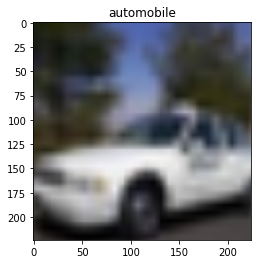

Following is an image from the val set


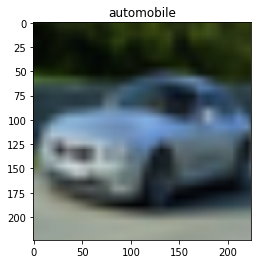

Following is an image from the test set


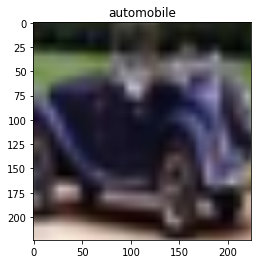

In [17]:
data_splits = {
    'train': train,
    'val': validation, 
    'test': test
}

random_img_inds = {
    this_ind : random.randint(0, data_splits[this_ind].__len__() - 1)
    
    for this_ind in [TRAIN, VAL, TEST]
}

for this_split in [TRAIN, VAL, TEST]:
    print('Following is an image from the {} set'.format(this_split))
    img_info = data_splits[this_split].__getitem__(random_img_inds[this_split])
    show_img(img_info, all_classes)
    


Define the DataLoaders using which we can iterate over the datasets batch-by-batch

In [18]:
dataloaders = {
    this_loader : DataLoader(data_splits[this_loader], batch_size = param_list['batch_size'], shuffle = True)
    
    for this_loader in [TRAIN, VAL, TEST]
}

In [51]:
k_random_sample_locs = random.sample([i for i in range(len(data_splits[TEST]))], 10)
k_random_samples = Subset(data_splits[TEST], k_random_sample_locs)
random_dl = DataLoader(k_random_samples)


In [55]:
p = [2,4,2,7,0,2,5,2,3,8]

In [57]:
for j, (im, lab) in enumerate(random_dl):
    if lab.data == p[j]:
        print('match!....................................................')
    print(j, im, lab)

0 tensor([[[[0.1843, 0.1843, 0.1843,  ..., 0.0588, 0.0588, 0.0588],
          [0.1882, 0.1882, 0.1882,  ..., 0.0627, 0.0627, 0.0627],
          [0.1882, 0.1882, 0.1882,  ..., 0.0627, 0.0627, 0.0627],
          ...,
          [0.7294, 0.7373, 0.7412,  ..., 0.6549, 0.6549, 0.6588],
          [0.7176, 0.7255, 0.7294,  ..., 0.6510, 0.6510, 0.6549],
          [0.7059, 0.7137, 0.7176,  ..., 0.6471, 0.6471, 0.6510]],

         [[0.2235, 0.2275, 0.2275,  ..., 0.0824, 0.0784, 0.0745],
          [0.2275, 0.2275, 0.2275,  ..., 0.0824, 0.0824, 0.0784],
          [0.2275, 0.2314, 0.2314,  ..., 0.0863, 0.0824, 0.0784],
          ...,
          [0.7451, 0.7490, 0.7529,  ..., 0.6510, 0.6510, 0.6549],
          [0.7333, 0.7373, 0.7412,  ..., 0.6471, 0.6471, 0.6510],
          [0.7255, 0.7255, 0.7294,  ..., 0.6431, 0.6431, 0.6471]],

         [[0.1294, 0.1333, 0.1333,  ..., 0.0510, 0.0510, 0.0471],
          [0.1333, 0.1333, 0.1333,  ..., 0.0549, 0.0510, 0.0510],
          [0.1333, 0.1373, 0.1373,  ...,

# Step 2: Define the model
The model definition can be found in vgg.py. Here it has been imported from that file.

# Step 3: Train the model
The following steps are the typical training steps for any PyTorch model:


We need to define a loss function and an optimizer with the required hyperparameters.

In [ ]:
# get the model first
model = param_list['confg'](attributes)

The size of the above model is about 450 MB !

In [ ]:
# define the cost function
criterion = nn.CrossEntropyLoss()

# to an optimizer object, we have to give it an iterable containing the parameters (all should be Variable s) to optimize. Then, we can specify optimizer-specific options such as the learning rate, weight decay, etc
# Now to get the parameters, model.parameters() returns an iterator over module parameters. See "https://pytorch.org/docs/stable/nn.html" for more info
optimizer = SGD(model.parameters(), lr = param_list['learning_rate'], momentum = 0.9, weight_decay=param_list['l2_weight_decay'])

The authors have varied the learning rate during training. They say:
_"The learning rate was initially set to 1e-2, and then decreased by a factor of 10 when the validation
set accuracy stopped improving. In total, the learning rate was decreased 3 times, and the learning
was stopped after 370K iterations (74 epochs)."_

In [ ]:
# implementing the same (although we might need to train for much fewer epochs):
# params: factor = 0.1 ==> reduce lr by 10%, patience = no. of epochs to monitor the optimizer before decreasing
# for more info, see docs. on torch.optim

# Note that during training, VGG_lr_scheduler.step() should be called after validate()
VGG_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2)

Training the model involves enumerating the DataLoader for the training dataset. And Each update to the model involves the same general pattern comprised of:

1. Clearing the last error gradient.
2. A forward pass of the input through the model.
3. Calculating the loss for the model output.
4. Backpropagating the error through the model.
5. Update the model in an effort to reduce loss.

In [ ]:
def train_vgg(dataloaders, criterion, optimizer, VGG_lr_scheduler, param_list):
    
    # a dictonary for storing losses and accuracies
    net_history = {}
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    print('Start training...')
    train_start = timer()
    best_acc = 0
    num_train_batches = len(dataloaders['train'])
    num_val_batches = len(dataloaders['val'])
    
    for epoch in range(param_list['epochs']):
        
        start_epoch = timer()
        train_loss, train_acc = 0, 0
        val_loss, val_acc = 0, 0
          
        ################################        IMPORTANT         ################################
        # indicate the model to work on training mode
        ##########################################################################################
        model.train(True)
        
        # mini-batch training by enumerating Dataloader object
        for batch_num, (inputs, targets) in enumerate(dataloaders[TRAIN]):
            
            if batch_num % 100 == 0:
                print('Training batch {}/{}'.format(batch_num, num_train_batches))
            
            # clear the previous gradients
            optimizer.zero_grad()
            
            # do a forward pass through the network
            # Ex:- if we have 64 images per batch, and 10 classes in the dataset, "output" will have shape of [10, 64]
            # "output will contain, for each image, the prediction probabilities"
            outputs = model(inputs)
            
            # get the predictions after the pass
            # using torch.max(a, dim=b) - returns the tensor a, and the max of tensor a along axis-b
            # .data was used with a Variable in earlier days - now can be used with Tensor object also 
            # torch.max returns the highest probabilities for each image in "_", and the corresponding labels in preds
            _, preds = torch.max(outputs.data, 1)
            
            # get the loss incurred - the data of tensor "outputs" can be fetched using .data attribute
            loss = criterion(outputs, targets)
            
            # do a backward pass
            loss.backward()
            
            # optimize this step
            optimizer.step()
            
            # loss is a single number (a pytorch tensor)- so can fetch its value using .item()
            # see docs: "https://pytorch.org/docs/stable/tensors.html"
            train_loss += loss.item()
            
            # find out the number of correct predictions for this batch
            train_acc += torch.sum(pred == targets.data)
            
            # delete the vars we don't need
            del inputs, targets, outputs, preds
            
        avg_train_loss = train_loss / data_splits[TRAIN]
        avg_train_acc = train_acc / data_splits[TRAIN]
        
        
        # now in each epoch we check our network's learning on the validation set once - in eval() mode
        # see this: "https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch"
        ################################        IMPORTANT         ################################
        # indicate the model to work on eval mode
        ##########################################################################################
        model.eval()
        
        for batch_num, (inputs, targets) in enumerate(dataloaders[VAL]):
            
            if batch_num % 100 == 0:
                print('Validation batch {}/{}'.format(batch_num, num_val_batches))
            
            # clear the previous gradients
            optimizer.zero_grad()
            
            # do a forward pass through the network
            outputs = model(inputs)
            
            # get the predictions after the pass
            # using torch.max(a, dim=b) - returns the tensor a, and the max of tensor a along axis-b
            # .data was used with a Variable in earlier days - now can be used with Tensor object also 
            _, preds = torch.max(outputs.data, 1)
            
            # get the loss incurred - the data of tensor "outputs" can be fetched using .data attribute
            loss = criterion(outputs, targets)
            
            # loss is a single number (a pytorch tensor)- so can fetch its value using .item()
            # see docs: "https://pytorch.org/docs/stable/tensors.html"
            val_loss += loss.item()
            
            # find out the number of correct predictions for this batch
            val_acc += torch.sum(pred == targets.data)
            
            # delete the vars we don't need
            del inputs, targets, outputs, preds
            
        avg_val_loss = val_loss / data_splits[VAL]
        avg_val_acc = val_acc / data_splits[VAL]
        
        
        ###################################    IMPORTANT    ##################################
        #           a step of scheduler - after validation loss has been calculated          #
        ######################################################################################
        VGG_lr_scheduler.step(avg_val_loss)   
        
        end_epoch = timer()
        
        # get the best weights till now
        if avg_val_acc > best_acc:
            best_acc = avg_val_acc
            # see for details: "https://stackoverflow.com/questions/56526698/best-state-changes-with-the-model-during-training-in-pytorch"
            # use deepcopy to get the last best state and not the last 'epoch state' 
            best_model_wts = copy.deepcopy(model.state_dict())
            
            
        # print the epoch results
        print('\nEpoch {}/{}, Runtime: {:.0f}m {:.0f}s ===> train_loss: {} - train_acc: {} - val_loss: {} - val_acc: {}'
        .format(epoch+1, param_list['epochs'], (end_epoch-start_epoch)//60, (end_epoch-start_epoch) % 60, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc))
        
        # store the history of this epoch
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)
        
        epoch += 1
    
    ############################################# end of training ################################################
    
    train_end = timer()
    print('\n\nTime taken to train: {:.0f}m {:.0f}s \t Best validation accuracy: {:.2f}'.format((train_end-train_start)//60, (train_end-train_start) % 60, best_acc))

    # get the best model to return it ...from where it could be saved
    model.load_state_dict(best_model_wts)
    
    # compose the net history
    net_history['train_loss'] = train_losses
    net_history['train_acc'] = train_accs
    net_history['val_acc'] = val_accs
    net_history['val_loss'] = val_losses
    net_history['model'] = model
    return net_history

Training has been defined. Now get the trained model and save it:

In [ ]:
vgg_model_with_history = train_vgg(dataloaders, criterion, optimizer, VGG_lr_scheduler, param_list)
saved_model_name = param_list['saved_model_name'] + '.pth'
torch.save(vgg_model_with_history, saved_model_name)

Once the trained model is with us, we can now evaluate it on the test set. Define the evaluation function as follows:

In [59]:
def evaluate_model(model, criterion, num_samples, dataloader, whole_test_set = True):
    
    print('Testing on {} sample(s)...'.format(num_samples))
    test_start = timer()
    num_test_batches = len(dataloader)

    test_loss, test_acc = 0, 0
    all_preds = []
    
    for batch_num, (inputs, targets) in enumerate(dataloader):

        model.eval()

        if batch_num % 100 == 0:
            print('Testing batch {}/{}'.format(batch_num, num_test_batches))

        # clear the previous gradients
        optimizer.zero_grad()

        # do a forward pass through the network
        # Ex:- if we have 64 images per batch, and 10 classes in the dataset, "output" will have shape of [10, 64]
        # "output will contain, for each image, the prediction probabilities"
        outputs = model(inputs)

        # get the predictions after the pass
        # using torch.max(a, dim=b) - returns the tensor a, and the max of tensor a along axis-b
        # .data was used with a Variable in earlier days - now can be used with Tensor object also 
        # torch.max returns the highest probabilities for each image in "_", and the corresponding labels in preds

        _, preds = torch.max(outputs.data, 1)
        
        if not whole_test_set:
            
            print(preds)
            # in this case, code understands that we are not testing on entire testing set - so dataloader will load one sample per run. So, we fetch the predictions to display
            # all_preds stores for each image, all the different probabilities predicted, and the label with highest probability
            all_preds.append((outputs.data, preds.data))
            
        # get the loss incurred - the data of tensor "outputs" can be fetched using .data attribute
        loss = criterion(outputs, targets)

        # loss is a single number (a pytorch tensor)- so can fetch its value using .item()
        # see docs: "https://pytorch.org/docs/stable/tensors.html"
        test_loss += loss.item()

        # find out the number of correct predictions for this batch
        test_acc += torch.sum(preds == targets.data)

        # delete the vars we don't need
        del inputs, targets, outputs, preds

    avg_test_loss = test_loss / num_samples
    avg_test_acc = test_acc / num_samples
    test_end = timer()
    
    return (test_end, test_start, avg_test_loss, avg_test_acc), all_preds

Also, define a visualization method to see the predictions as follows:

In [ ]:
def display_k_preds(k, random_dl, k_random_preds):
    
    num_classes = len(all_classes)

    # unpack the output probs. and predicted labels of highest confidence
    (different_probs, pred_labels) = zip(*k_random_preds)
    
    # define plot area - structure: image and probability distribution bar plots - horizontally stacked - so subplot arguments are (k, 2)
    if k > 1:
        fig, axs = plt.subplots(k, 2, figsize=(12,24))
    else:
        fig, axs = plt.subplots(k, 2, figsize=(5, 5))
    
    margin = 0.05
    ind = np.arange(num_classes)
    width = (1. - 2. * margin) / num_classes  

    # plot for all the k images 
    for img_index, (this_img, this_label) in enumerate(random_dl):

        label_matched = False

        # check if actual label of this_img matches with predicted label (the one with highest probability)  
        if this_label.data == pred_labels[img_index]:
            label_matched = True

        # plot the result and store the prediction probabilities if required
        all_pred_names = []
        all_pred_probs = []

        # for this image, plot the required graph and also inform the different probabilities for all classes
        for i, pred in enumerate(different_probs[img_index]):

            tmp_label_name = all_classes[i]
            all_pred_probs.append({tmp_label_name: pred})
            all_pred_names.append(tmp_label_name)

        print('Image [{}]==> Ground truth: {}; Prediction: {}; Match found: {}'.format(img_index, all_classes[this_label], pred_labels[img_index], label_matched))
        #print('\tDifferent probabilities predicted:- {}\n'.format(all_pred_probs))
      
        if k > 1:
            # test of multiple images
            axs[img_index][0].imshow(this_img)
            axs[img_index][0].set_title(all_classes[this_label])
            axs[img_index][0].set_axis_off()
            
            axs[img_index][1].barh(ind + margin, different_probs[img_index], width)
            axs[img_index][1].set_yticks(ind + margin)
            axs[img_index][1].set_yticklabels(all_pred_names)

        else:
            # test of single image
            axs[0].imshow(this_img)
            axs[0].set_title(all_classes[this_label])
            axs[0].set_axis_off()

            axs[1].barh(ind + margin, different_probs[img_index], width)
            axs[1].set_yticks(ind + margin)
            axs[1].set_yticklabels(all_pred_names)        
    
    plt.tight_layout()
      

In [65]:
def test_model(model, criterion, k = 10, only_k = False, given_sample = None):
    
    # three modes of testing:
    # test on entire test set, show test reults on k random images, or show test result on a single image
    if given_sample is None:
        
        if not only_k:
            
            # have to print test accuracy of entire test set as well as do random k predictions and show
            (test_end, test_start, avg_test_loss, avg_test_acc), _ =  evaluate_model(model, criterion, len(data_splits[TEST], dataloaders[TEST]), whole_test_set = True)

            print('Time taken to test {} samples: {:.0f}m {:.0f}s \nAverage test loss: {} \n Average test accuracy: {}'
                  .format(len(data_splits[TEST]),
                          (test_end - test_start) // 60,
                          (test_end - test_start) % 60,
                          avg_test_loss,
                          avg_test_acc
                             ))
            
        # now get out k images out of the test set
        k_random_sample_locs = random.sample([i for i in range(len(data_splits[TEST]))], k)
        k_random_samples = Subset(data_splits[TEST], k_random_sample_locs)
        random_dl = DataLoader(k_random_samples)
        _, k_random_preds = evaluate_model(model, criterion, k, random_dl, whole_test_set = False)
        display_k_preds(k, random_dl, k_random_preds)
        
        
    else:
        
        # for a single image
        _, out_pred = evaluate_model(model, criterion, 1, given_sample, whole_test_set = False)
        display_k_preds(1, given_sample, out_pred)

See what acuracy you achieve...

In [ ]:
# test on the entire test dataset, and show results on 10 random images
test_model(vgg_model_with_history['model'], criterion)

In [ ]:
# test on a single image
test_model(vgg_model_with_history['model'], criterion, given_sample = test.__getitem__(12))